# Imports

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import folium
import pycountry
from shapely import wkt
import networkx as nx
import dill

In [2]:
pd.set_option('display.max_columns', None)

# Reading the SciGRID data

In [3]:
scigrid_pipe_segments_df = pd.read_csv('Scigrid_data/IGGIN_PipeSegments.csv', delimiter=';')
scigrid_nodes_df = pd.read_csv('Scigrid_data/IGGIN_Nodes.csv', delimiter=';')

# Cleaning up columns

## Dropping

In [4]:
scigrid_nodes_df = scigrid_nodes_df.drop(columns=['source_id', 'param', 'uncertainty', 'method', 'tags'])
scigrid_pipe_segments_df = scigrid_pipe_segments_df.drop(columns=['source_id', 'uncertainty', 'method', 'tags'])

## Splitting

In [5]:
def split_col_to_and_from(df, col, type):
    try:
        df[col] = df[col].apply(lambda x: json.loads(x.replace("'", '"')))
        if type == 'str':
            df[col] = df[col].apply(lambda x: [str(i) for i in x])
        elif type == 'int':
            df[col] = df[col].apply(lambda x: [int(i) for i in x])
        elif type == 'float':
            df[col] = df[col].apply(lambda x: [float(i) for i in x])
        df['from_' + col] = df[col].apply(lambda x: x[0])
        df['to_' + col] = df[col].apply(lambda x: x[1])
        df = df.drop(columns=[col])
    except Exception as e:
        print(f"An error occurred while processing column '{col}': {str(e)}")
    return df

def split_coords (df, col):
    # The 'lat' and 'long' columns both on the format "[60.54204007494405, 60.54266109350547, 60.54330065370974, 60.56023487203963]"
    # We want to split this into four columns: 'from_lat', 'from_long', 'to_lat', 'to_long'
    # The first value in each column is the value of the start node, from_lat and from_long, and the last value is the end node, to_lat and to_long
    try:
        df[col] = df[col].apply(lambda x: json.loads(x.replace("'", '"')))
        df['from_' + col] = df[col].apply(lambda x: x[0])
        df['to_' + col] = df[col].apply(lambda x: x[-1])
        df = df.drop(columns=[col])
    except Exception as e:
        print(f"An error occurred while processing column '{col}': {str(e)}")
    return df

In [6]:
# 'param' column in scigrid_pipe_segments_df
scigrid_pipe_segments_df['param'] = scigrid_pipe_segments_df['param'].apply(lambda x: json.loads(x.replace("'", '"')))
param_df = pd.json_normalize(scigrid_pipe_segments_df['param'])
scigrid_pipe_segments_df = scigrid_pipe_segments_df.drop(columns=['param']).join(param_df)

In [7]:
# 'node_id' column in scigrid_pipe_segments_df@
scigrid_pipe_segments_df = split_col_to_and_from(scigrid_pipe_segments_df, 'node_id', 'str')

# 'country_code' column in scigrid_pipe_segments_df
scigrid_pipe_segments_df = split_col_to_and_from(scigrid_pipe_segments_df, 'country_code', 'str')

# 'lat' column in scigrid_pipe_segments_df
scigrid_pipe_segments_df = split_coords(scigrid_pipe_segments_df, 'lat')

# 'long' column in scigrid_pipe_segments_df
scigrid_pipe_segments_df = split_coords(scigrid_pipe_segments_df, 'long')

<Axes: ylabel='Frequency'>

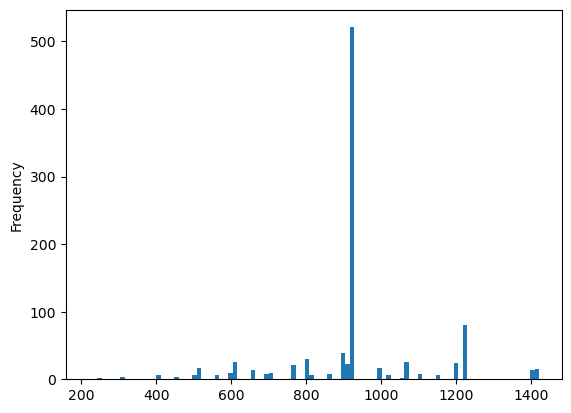

In [8]:
# Plot a distribution of the max_cap_M_m3_per_d column
scigrid_pipe_segments_df['diameter_mm'].plot(kind='hist', bins=100)

In [9]:
scigrid_pipe_segments_df.columns

Index(['id', 'name', 'comment', 'diameter_mm', 'end_year', 'is_H_gas',
       'is_bothDirection', 'lat_mean', 'length_km', 'long_mean',
       'max_cap_M_m3_per_d', 'max_pressure_bar', 'num_compressor',
       'start_year', 'waterDepth_m', 'from_node_id', 'to_node_id',
       'from_country_code', 'to_country_code', 'from_lat', 'to_lat',
       'from_long', 'to_long'],
      dtype='object')

# Adding pipelines from GEM dataset

## Helper functions

In [10]:
def check_node_columns_scigrid(nodes_df):
    # Check that the columns of the nodes_df are as expected
    assert list(nodes_df.columns) == ['id', 'name', 'node_id', 'lat', 'long', 'country_code', 'comment'], 'The columns of the nodes_df are not as expected'

def check_pipe_columns_scigrid(scigrid_pipes_df):
    # Check that the columns of the scigrid_pipes_df are as expected
    assert list(scigrid_pipes_df.columns) == ['id', 'name', 'comment', 'diameter_mm', 'end_year', 'is_H_gas', 'is_bothDirection', 'lat_mean', 'length_km', 'long_mean', 'max_cap_M_m3_per_d', 'max_pressure_bar', 'num_compressor', 'start_year', 'waterDepth_m', 'from_node_id', 'to_node_id', 'from_country_code', 'to_country_code', 'from_lat', 'to_lat', 'from_long', 'to_long'], 'The columns of the scigrid_pipes_df are not as expected'

def check_pipe_columns_gem(gem_pipes_df):
    # Check that the gem_pipes_df has the needed columns
    assert 'geometry' in gem_pipes_df.columns, 'The gem_pipes_df does not have the geometry column'
    assert 'CapacityBcm/y' in gem_pipes_df.columns, 'The gem_pipes_df does not have the CapacityBcm/y column'
    assert 'StartLocation' in gem_pipes_df.columns, 'The gem_pipes_df does not have the StartLocation column'
    assert 'StartCountry' in gem_pipes_df.columns, 'The gem_pipes_df does not have the StartCountry column'
    assert 'ProjectID' in gem_pipes_df.columns, 'The gem_pipes_df does not have the ProjectID column'
    assert 'PipelineName' in gem_pipes_df.columns, 'The gem_pipes_df does not have the PipelineName column'
    assert 'LengthKnownKm' in gem_pipes_df.columns, 'The gem_pipes_df does not have the LengthKnownKm column'
    assert 'StartYear1' in gem_pipes_df.columns, 'The gem_pipes_df does not have the StartYear1 column'

In [11]:
def add_pipeline_to_scigrid_df(ProjectID, end_node_id, nodes_df, scigrid_pipes_df, gem_pipes_df, start_node = "First", start_node_id = None):
    
    # Check that the dataframes have the expected columns
    check_node_columns_scigrid(nodes_df)
    check_pipe_columns_scigrid(scigrid_pipes_df)
    check_pipe_columns_gem(gem_pipes_df)

    # Check that the ProjectID is in the gem_pipes_df
    assert ProjectID in gem_pipes_df['ProjectID'].values, 'The ProjectID is not in the gem_pipes_df'

    # Check that the end_node_id is in the nodes_df
    assert end_node_id in nodes_df['id'].values, 'The end_node_id is not in the nodes_df'

    # start_node_id values
    new_node_id = None
    new_node_name = None
    new_node_lat = None
    new_node_long = None
    new_node_country_code = None
    new_node_comment = None

    if start_node_id is None:
        # Create a new entry in the nodes_df, corresponding to the start node of the pipeline

        # Set the 'id' of the new node to be 'N_' + 'ProjectID'
        new_node_id = 'N_' + str(ProjectID)
        
        # Set the name of the new node to be the 'StartLocation' of the pipeline. If the 'StartLocation' is not available, use the new_node_id
        try:
            new_node_name = gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['StartLocation'].values[0]
        except:
            new_node_name = new_node_id

        # Set the 'lat' and 'long' of the new node to be the first point in the 'geometry' of the pipeline. The geometry is a WWKT string, so we can use the 'xy' attribute of the 'geometry' to get the lat and lon
            
        # If start_node = "First", set the 'lat' and 'long' of the new node to be the first point in the 'geometry' of the pipeline
        if start_node == "First":
            new_node_lat = wkt.loads(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['geometry'].values[0]).xy[1][0]    
            new_node_long = wkt.loads(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['geometry'].values[0]).xy[0][0]
        # If start_node = "Last", set the 'lat' and 'long' of the new node to be the last point in the 'geometry' of the pipeline
        elif start_node == "Last":
            new_node_lat = wkt.loads(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['geometry'].values[0]).xy[1][-1]    
            new_node_long = wkt.loads(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['geometry'].values[0]).xy[0][-1]

        # Set the 'country_code' of the new node to be the alpha-2 code of the 'StartCountry' of the pipeline
        try:
            new_node_country_code = pycountry.countries.get(name=gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['StartCountry'].values[0]).alpha_2
        except:
            # If StartCountry = Russia, set the country code to RU
            if gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['StartCountry'].values[0] == 'Russia':
                new_node_country_code = 'RU'
            else:
                # Print a warning if the alpha-2 code is not available
                print(f"The alpha-2 code for the country with name: {gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['StartCountry'].values[0]} is not available")
                new_node_country_code = 'NA'

        # Set the 'comment' to: "This node was created to represent the start of the pipeline with ProjectID: " + ProjectID
        new_node_comment = "This node was created to represent the start of the pipeline with ProjectID: " + ProjectID

        # Insert the new node into the nodes_df
        new_node = pd.DataFrame({'id': [new_node_id],
                                'name': [new_node_name],
                                'node_id': [new_node_id],
                                'lat': [new_node_lat],
                                'long': [new_node_long],
                                'country_code': [new_node_country_code],
                                'comment': [new_node_comment]})
        nodes_df = pd.concat([nodes_df, new_node], ignore_index=True)
    
    else:
        # Check that the start_node_id is in the nodes_df
        assert start_node_id in nodes_df['id'].values, 'The start_node_id is not in the nodes_df'

        # Set the new_node_id, new_node_name, new_node_lat, new_node_long, new_node_country_code, and new_node_comment to be the values of the start_node_id
        new_node_id = start_node_id
        new_node_name = nodes_df[nodes_df['id'] == start_node_id]['name'].values[0]
        new_node_lat = nodes_df[nodes_df['id'] == start_node_id]['lat'].values[0]
        new_node_long = nodes_df[nodes_df['id'] == start_node_id]['long'].values[0]
        new_node_country_code = nodes_df[nodes_df['id'] == start_node_id]['country_code'].values[0]
        new_node_comment = nodes_df[nodes_df['id'] == start_node_id]['comment'].values[0]

    # Create a new entry in the scigrid_pipes_df, corresponding to the pipeline

    # Check if the pipeline has been created before, by checking if 'P_' + 'ProjectID' is in the scigrid_pipes_df
    if 'P_' + str(ProjectID) in scigrid_pipes_df['id'].values:
        # If the pipeline has been created before, raise an error
        raise ValueError('The pipeline has already been created')
    
    # Set the 'id' of the new pipeline to be 'P_' + 'ProjectID'
    new_pipeline_id = 'P_' + str(ProjectID)

    # Set the name of the new pipeline to be the 'PipelineName' of the pipeline. If the 'PipelineName' is not available, use the new_pipeline_id
    try:
        new_pipeline_name = gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['PipelineName'].values[0]
    except:
        new_pipeline_name = new_pipeline_id
    
    # Set the 'comment' to: "This pipeline was created to represent the pipeline with ProjectID: " + ProjectID
    new_pipeline_comment = "This pipeline was created to represent the pipeline with ProjectID: " + ProjectID

    # Try to set the diameter_mm of the new pipeline to be the "Diameter" of the pipeline. If the "Diameter" is not available, set it to 0
    try:
        new_pipeline_diameter_mm = gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['Diameter'].values[0]
        
        # Convert the diameter from inches to mm
        new_pipeline_diameter_mm = new_pipeline_diameter_mm * 25.4

    except:
        new_pipeline_diameter_mm = 0

    # Setting other properties of the pipeline
    new_pipeline_end_year = 2050
    new_pipeline_is_H_gas = 1.0
    new_pipeline_is_bothDirection = 0.0
    new_pipeline_max_pressure_bar = float('nan')
    new_pipeline_waterdepth_m = float('nan')
    new_pipeline_num_compressor = 0

    # Set the lat_mean and long_mean of the new pipeline to be the mean of the 'lat' and 'long' of the new node and the 'lat' and 'long' of the end node
    new_pipeline_lat_mean = (new_node_lat + nodes_df[nodes_df['id'] == end_node_id]['lat'].values[0]) / 2
    new_pipeline_long_mean = (new_node_long + nodes_df[nodes_df['id'] == end_node_id]['long'].values[0]) / 2

    # Set the length_km of the new pipeline to be the "LengthKnownKm" of the pipeline
    try:
        new_pipeline_length_km = float(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['LengthKnownKm'].values[0])
    except:
        # Print a warning if the "LengthKnownKm" is not available
        print(f"The 'LengthKnownKm' for the pipeline with ProjectID: {ProjectID} is not available")
        new_pipeline_length_km = 0
    
    # Set the max_cap_M_m3_per_d of the new pipeline to be the "CapacityBcm/y" of the pipeline
    try:
        new_pipeline_max_cap_M_m3_per_d = float(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['CapacityBcm/y'].values[0])
        
        # Convert the capacity from Bcm/y to M_m3/d
        new_pipeline_max_cap_M_m3_per_d = new_pipeline_max_cap_M_m3_per_d * 1000 / 365

    except:
        # Print a warning if the "CapacityBcm/y" is not available. Print the pipeline name
        print(f"The 'CapacityBcm/yy' for the pipeline {gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['PipelineName'].values[0]} is not available")
        
        # Setting the capacity to 45.510317, which is the most common capacity in the dataset
        new_pipeline_max_cap_M_m3_per_d = 45.510317

    
    #  Set the start_year of the new pipeline to be the "StartYear1" of the pipeline
    try:
        new_pipeline_start_year = int(gem_pipes_df[gem_pipes_df['ProjectID'] == ProjectID]['StartYear1'].values[0])
    except:
        # Print a warning if the "StartYear1" is not available
        print(f"The 'StartYear1' for the pipeline with ProjectID: {ProjectID} is not available")
        new_pipeline_start_year = 0
    
    # Setting to and from values
    new_pipeline_from_node_id = new_node_id
    new_pipeline_to_node_id = end_node_id
    new_pipeline_from_country_code = new_node_country_code
    new_pipeline_to_country_code = nodes_df[nodes_df['id'] == end_node_id]['country_code'].values[0]
    new_pipeline_from_lat = new_node_lat
    new_pipeline_to_lat = nodes_df[nodes_df['id'] == end_node_id]['lat'].values[0]
    new_pipeline_from_long = new_node_long
    new_pipeline_to_long = nodes_df[nodes_df['id'] == end_node_id]['long'].values[0]

    # Insert the new pipeline into the scigrid_pipes_df
    new_pipeline_data = {
        'id': [new_pipeline_id],
        'name': [new_pipeline_name],
        'comment': [new_pipeline_comment],
        'diameter_mm': [new_pipeline_diameter_mm],
        'end_year': [new_pipeline_end_year],
        'is_H_gas': [new_pipeline_is_H_gas],
        'is_bothDirection': [new_pipeline_is_bothDirection],
        'lat_mean': [new_pipeline_lat_mean],
        'length_km': [new_pipeline_length_km],
        'long_mean': [new_pipeline_long_mean],
        'max_cap_M_m3_per_d': [new_pipeline_max_cap_M_m3_per_d],
        'max_pressure_bar': [new_pipeline_max_pressure_bar],
        'num_compressor': [new_pipeline_num_compressor],
        'start_year': [new_pipeline_start_year],
        'waterDepth_m': [new_pipeline_waterdepth_m],
        'from_node_id': [new_pipeline_from_node_id],
        'to_node_id': [new_pipeline_to_node_id],
        'from_country_code': [new_pipeline_from_country_code],
        'to_country_code': [new_pipeline_to_country_code],
        'from_lat': [new_pipeline_from_lat],
        'to_lat': [new_pipeline_to_lat],
        'from_long': [new_pipeline_from_long],
        'to_long': [new_pipeline_to_long]
    }
    
    scigrid_pipes_df = pd.concat([scigrid_pipes_df, pd.DataFrame(new_pipeline_data)], ignore_index=True)

    return nodes_df, scigrid_pipes_df

In [12]:
def split_pipline_into_legs(ProjectID, node_id, nodes_df, pipelines_df):

    # Check that the dataframes have the expected columns
    check_node_columns_scigrid(nodes_df)
    check_pipe_columns_scigrid(pipelines_df)

    # Check that the ProjectID is in the pipelines_df
    assert 'P_' + str(ProjectID) in pipelines_df['id'].values, 'The ProjectID is not in the pipelines_df'

    # Check that the node_id is in the nodes_df
    assert node_id in nodes_df['id'].values, 'The node_id is not in the nodes_df'

    # Create two new pipelines in the pipelines_df, corresponding to the legs of the pipeline

    # Set the 'id' of the new pipelines to be 'P_' + 'ProjectID' + '_1' and 'P_' + 'ProjectID' + '_2'
    new_pipeline_id_1 = 'P_' + str(ProjectID) + '_1'
    new_pipeline_id_2 = 'P_' + str(ProjectID) + '_2'

    # Set the name of the new pipelines to be the 'name' of the pipeline + '_1' and '_2'
    new_pipeline_name_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['name'].values[0] + '_1'
    new_pipeline_name_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['name'].values[0] + '_2'

    # Set the 'comment' to: "This pipeline was created by splitting the pipeline with ProjectID: " + ProjectID + " at node with id: " + node_id
    new_pipeline_comment_1 = "This pipeline was created by splitting the pipeline with ProjectID: " + ProjectID + " at node with id: " + node_id
    new_pipeline_comment_2 = "This pipeline was created by splitting the pipeline with ProjectID: " + ProjectID + " at node with id: " + node_id

    # Set the diameter_mm of the new pipelines to be the "diameter_mm" of the pipeline
    new_pipeline_diameter_mm_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['diameter_mm'].values[0]
    new_pipeline_diameter_mm_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['diameter_mm'].values[0]

    # Set the end_year of the new pipelines to be the "end_year" of the pipeline
    new_pipeline_end_year_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['end_year'].values[0]
    new_pipeline_end_year_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['end_year'].values[0]

    # Set the is_H_gas of the new pipelines to be the "is_H_gas" of the pipeline
    new_pipeline_is_H_gas_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['is_H_gas'].values[0]
    new_pipeline_is_H_gas_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['is_H_gas'].values[0]

    # Set the is_bothDirection of the new pipelines to be the "is_bothDirection" of the pipeline
    new_pipeline_is_bothDirection_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['is_bothDirection'].values[0]
    new_pipeline_is_bothDirection_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['is_bothDirection'].values[0]

    # Set the max_pressure_bar of the new pipelines to be the "max_pressure_bar" of the pipeline
    new_pipeline_max_pressure_bar_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['max_pressure_bar'].values[0]
    new_pipeline_max_pressure_bar_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['max_pressure_bar'].values[0]

    # Set the waterdepth_m of the new pipelines to be the "waterdepth_m" of the pipeline
    new_pipeline_waterdepth_m_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['waterDepth_m'].values[0]
    new_pipeline_waterdepth_m_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['waterDepth_m'].values[0]

    # Set the num_compressor of the new pipelines to be the "num_compressor" of the pipeline
    new_pipeline_num_compressor_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['num_compressor'].values[0]
    new_pipeline_num_compressor_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['num_compressor'].values[0]

    # Set the lat_mean and long_mean of the new pipelines to be the mean of the 'lat' and 'long' of the new node and the 'lat' and 'long' of the end node
    new_pipeline_lat_mean_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['lat_mean'].values[0]
    new_pipeline_long_mean_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['long_mean'].values[0]
    new_pipeline_lat_mean_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['lat_mean'].values[0]
    new_pipeline_long_mean_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['long_mean'].values[0]

    # Set the length_km of the new pipelines to be nan
    new_pipeline_length_km_1 = float('nan')
    new_pipeline_length_km_2 = float('nan')

    # Set the max_cap_M_m3_per_d of the new pipelines to be the "max_cap_M_m3_per_d" of the pipeline
    new_pipeline_max_cap_M_m3_per_d_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['max_cap_M_m3_per_d'].values[0]
    new_pipeline_max_cap_M_m3_per_d_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['max_cap_M_m3_per_d'].values[0]

    # Set the start_year of the new pipelines to be the "start_year" of the pipeline
    new_pipeline_start_year_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['start_year'].values[0]
    new_pipeline_start_year_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['start_year'].values[0]

    # Setting to and from values
    # Let the from values for the first leg be the same as the from values of the original pipeline
    new_pipeline_from_node_id_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['from_node_id'].values[0]
    new_pipeline_from_country_code_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['from_country_code'].values[0]
    new_pipeline_from_lat_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['from_lat'].values[0]
    new_pipeline_from_long_1 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['from_long'].values[0]

    # Let the to values for the first leg be the same as the node_id and to values of the original pipeline
    new_pipeline_to_node_id_1 = node_id
    new_pipeline_to_country_code_1 = nodes_df[nodes_df['id'] == node_id]['country_code'].values[0]
    new_pipeline_to_lat_1 = nodes_df[nodes_df['id'] == node_id]['lat'].values[0]
    new_pipeline_to_long_1 = nodes_df[nodes_df['id'] == node_id]['long'].values[0]

    # Let the from values for the second leg be the same as the node_id and from values of the original pipeline
    new_pipeline_from_node_id_2 = node_id
    new_pipeline_from_country_code_2 = nodes_df[nodes_df['id'] == node_id]['country_code'].values[0]
    new_pipeline_from_lat_2 = nodes_df[nodes_df['id'] == node_id]['lat'].values[0]
    new_pipeline_from_long_2 = nodes_df[nodes_df['id'] == node_id]['long'].values[0]

    # Let the to values for the second leg be the same as the to values of the original pipeline
    new_pipeline_to_node_id_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['to_node_id'].values[0]
    new_pipeline_to_country_code_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['to_country_code'].values[0]
    new_pipeline_to_lat_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['to_lat'].values[0]
    new_pipeline_to_long_2 = pipelines_df[pipelines_df['id'] == 'P_' + str(ProjectID)]['to_long'].values[0]

    # Insert the new pipelines into the pipelines_df
    new_pipeline_data_1 = {
        'id': [new_pipeline_id_1],
        'name': [new_pipeline_name_1],
        'comment': [new_pipeline_comment_1],
        'diameter_mm': [new_pipeline_diameter_mm_1],
        'end_year': [new_pipeline_end_year_1],
        'is_H_gas': [new_pipeline_is_H_gas_1],
        'is_bothDirection': [new_pipeline_is_bothDirection_1],
        'lat_mean': [new_pipeline_lat_mean_1],
        'length_km': [new_pipeline_length_km_1],
        'long_mean': [new_pipeline_long_mean_1],
        'max_cap_M_m3_per_d': [new_pipeline_max_cap_M_m3_per_d_1],
        'max_pressure_bar': [new_pipeline_max_pressure_bar_1],
        'num_compressor': [new_pipeline_num_compressor_1],
        'start_year': [new_pipeline_start_year_1],
        'waterDepth_m': [new_pipeline_waterdepth_m_1],
        'from_node_id': [new_pipeline_from_node_id_1],
        'to_node_id': [new_pipeline_to_node_id_1],
        'from_country_code': [new_pipeline_from_country_code_1],
        'to_country_code': [new_pipeline_to_country_code_1],
        'from_lat': [new_pipeline_from_lat_1],
        'to_lat': [new_pipeline_to_lat_1],
        'from_long': [new_pipeline_from_long_1],
        'to_long': [new_pipeline_to_long_1]
    }

    new_pipeline_data_2 = {
        'id': [new_pipeline_id_2],
        'name': [new_pipeline_name_2],
        'comment': [new_pipeline_comment_2],
        'diameter_mm': [new_pipeline_diameter_mm_2],
        'end_year': [new_pipeline_end_year_2],
        'is_H_gas': [new_pipeline_is_H_gas_2],
        'is_bothDirection': [new_pipeline_is_bothDirection_2],
        'lat_mean': [new_pipeline_lat_mean_2],
        'length_km': [new_pipeline_length_km_2],
        'long_mean': [new_pipeline_long_mean_2],
        'max_cap_M_m3_per_d': [new_pipeline_max_cap_M_m3_per_d_2],
        'max_pressure_bar': [new_pipeline_max_pressure_bar_2],
        'num_compressor': [new_pipeline_num_compressor_2],
        'start_year': [new_pipeline_start_year_2],
        'waterDepth_m': [new_pipeline_waterdepth_m_2],
        'from_node_id': [new_pipeline_from_node_id_2],
        'to_node_id': [new_pipeline_to_node_id_2],
        'from_country_code': [new_pipeline_from_country_code_2],
        'to_country_code': [new_pipeline_to_country_code_2],
        'from_lat': [new_pipeline_from_lat_2],
        'to_lat': [new_pipeline_to_lat_2],
        'from_long': [new_pipeline_from_long_2],
        'to_long': [new_pipeline_to_long_2]
    }

    pipelines_df = pd.concat([pipelines_df, pd.DataFrame(new_pipeline_data_1), pd.DataFrame(new_pipeline_data_2)], ignore_index=True)
    
    # Remove the original pipeline from the pipelines_df
    pipelines_df = pipelines_df[pipelines_df['id'] != 'P_' + str(ProjectID)]

    return pipelines_df

## Adding missing nodes

In [13]:
# Add Shebelinka, Ukraine (49.445577, 36.523075) to scigrid_nodes_df, using concat
shebelinka = pd.DataFrame({'id': ["N_shebelinka"], 'name': ["Shebelinka"], 'node_id': ["N_shebelinka"], 'lat': [49.445577], 'long': [36.523075], 'country_code': ["UA"], 'comment': ["Shebelinka, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, shebelinka])

# Add Novopskov (49.528877, 39.085551) to scigrid_nodes_df, using concat
novopskov = pd.DataFrame({'id': ["N_novopskov"], 'name': ["Novopskov"], 'node_id': ["N_novopskov"], 'lat': [49.528877], 'long': [39.085551], 'country_code': ["UA"], 'comment': ["Novopskov, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, novopskov])

# Add Kiev (50.4501, 30.5234) to scigrid_nodes_df, using concat
kiev = pd.DataFrame({'id': ["N_kiev"], 'name': ["Kiev"], 'node_id': ["N_kiev"], 'lat': [50.4501], 'long': [30.5234], 'country_code': ["UA"], 'comment': ["Kiev, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, kiev])

# Add Anaiiv, Ukraine (47.7175, 29.9764) to scigrid_nodes_df, using concat
anaiiv = pd.DataFrame({'id': ["N_anaiiv"], 'name': ["Anaiiv"], 'node_id': ["N_anaiiv"], 'lat': [47.7175], 'long': [29.9764], 'country_code': ["UA"], 'comment': ["Anaiiv, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, anaiiv])

# Add Bohorodchany, Ukraine (48.8103, 24.8804) to scigrid_nodes_df, using concat
bohorodchany = pd.DataFrame({'id': ["N_bohorodchany"], 'name': ["Bohorodchany"], 'node_id': ["N_bohorodchany"], 'lat': [48.8103], 'long': [24.8804], 'country_code': ["UA"], 'comment': ["Bohorodchany, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, bohorodchany])

# Add Dolyna, Ukraine (48.9736, 24.0056) to scigrid_nodes_df, using concat
dolyna = pd.DataFrame({'id': ["N_dolyna"], 'name': ["Dolyna"], 'node_id': ["N_dolyna"], 'lat': [48.9736], 'long': [24.0056], 'country_code': ["UA"], 'comment': ["Dolyna, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, dolyna])

# Add Torzhok, Russia (57.0419, 34.9609) to scigrid_nodes_df, using concat
torzhok = pd.DataFrame({'id': ["N_torzhok"], 'name': ["Torzhok"], 'node_id': ["N_torzhok"], 'lat': [57.0419], 'long': [34.9609], 'country_code': ["RU"], 'comment': ["Torzhok, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, torzhok])

# Add Urengoy, Russia (65.9667, 78.3667) to scigrid_nodes_df, using concat
urengoy = pd.DataFrame({'id': ["N_urengoy"], 'name': ["Urengoy"], 'node_id': ["N_urengoy"], 'lat': [65.9667], 'long': [78.3667], 'country_code': ["RU"], 'comment': ["Urengoy, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, urengoy])

# Add Yamburg, Russia (67.914984, 74.889238) to scigrid_nodes_df, using concat
yamburg = pd.DataFrame({'id': ["N_yamburg"], 'name': ["Yamburg"], 'node_id': ["N_yamburg"], 'lat': [67.914984], 'long': [74.889238], 'country_code': ["RU"], 'comment': ["Yamburg, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, yamburg])

# Add Yelets, Russia (52.6231, 38.5016) to scigrid_nodes_df, using concat
yelets = pd.DataFrame({'id': ["N_yelets"], 'name': ["Yelets"], 'node_id': ["N_yelets"], 'lat': [52.6231], 'long': [38.5016], 'country_code': ["RU"], 'comment': ["Yelets, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, yelets])

# Add Kursk, Russia (51.7092, 36.1562) to scigrid_nodes_df, using concat
kursk = pd.DataFrame({'id': ["N_kursk"], 'name': ["Kursk"], 'node_id': ["N_kursk"], 'lat': [51.7092], 'long': [36.1562], 'country_code': ["RU"], 'comment': ["Kursk, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, kursk])

# Add Kryvyi, Ukraine (47.9100, 33.3911) to scigrid_nodes_df, using concat
kryvyi = pd.DataFrame({'id': ["N_kryvyi"], 'name': ["Kryvyi"], 'node_id': ["N_kryvyi"], 'lat': [47.9100], 'long': [33.3911], 'country_code': ["UA"], 'comment': ["Kryvyi, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, kryvyi])

# Add Dykanka, Ukraine (50.2600, 34.3300) to scigrid_nodes_df, using concat
dykanka = pd.DataFrame({'id': ["N_dykanka"], 'name': ["Dykanka"], 'node_id': ["N_dykanka"], 'lat': [50.2600], 'long': [34.3300], 'country_code': ["UA"], 'comment': ["Dykanka, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, dykanka])

# Add Kremenchuk, Ukraine (49.0833, 33.4167) to scigrid_nodes_df, using concat
kremenchuk = pd.DataFrame({'id': ["N_kremenchuk"], 'name': ["Kremenchuk"], 'node_id': ["N_kremenchuk"], 'lat': [49.0833], 'long': [33.4167], 'country_code': ["UA"], 'comment': ["Kremenchuk, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, kremenchuk])

# Add Russkaya, Russia (44.5000, 39.5000) to scigrid_nodes_df, using concat
russkaya = pd.DataFrame({'id': ["N_russkaya"], 'name': ["Russkaya"], 'node_id': ["N_russkaya"], 'lat': [44.5000], 'long': [39.5000], 'country_code': ["RU"], 'comment': ["Russkaya, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, russkaya])

# Add Poltava, Ukraine (49.5883, 34.5519) to scigrid_nodes_df, using concat
poltava = pd.DataFrame({'id': ["N_poltava"], 'name': ["Poltava"], 'node_id': ["N_poltava"], 'lat': [49.5883], 'long': [34.5519], 'country_code': ["UA"], 'comment': ["Poltava, Ukraine"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, poltava])

# Add Orenburg, Russia (51.7727, 55.0988) to scigrid_nodes_df, using concat
orenburg = pd.DataFrame({'id': ["N_orenburg"], 'name': ["Orenburg"], 'node_id': ["N_orenburg"], 'lat': [51.7727], 'long': [55.0988], 'country_code': ["RU"], 'comment': ["Orenburg, Russia"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, orenburg])

# Add Hassi R'Mel, Algeria (32.9333, 3.2833) to scigrid_nodes_df, using concat
hassi = pd.DataFrame({'id': ["N_hassi"], 'name': ["Hassi R'Mel"], 'node_id': ["N_hassi"], 'lat': [32.9333], 'long': [3.2833], 'country_code': ["DZ"], 'comment': ["Hassi R'Mel, Algeria"]})
scigrid_nodes_df = pd.concat([scigrid_nodes_df, hassi])

## Reading the GEM Global Gas Tracker data

In [14]:
europe_gas_pipelines_df = pd.read_csv('GEM-data/GEM-GGIT-Gas-Pipelines-2023-12.csv')
# europe_gas_pipelines_df = europe_gas_pipelines_df.rename(columns={'WKTFormat': 'geometry'})

## Adding pipelines

In [15]:
print(europe_gas_pipelines_df[europe_gas_pipelines_df['PipelineName'] == "Efremovka-Dikanka-Kiev Gas Pipeline"]['ProjectID'].values[0])

P1453


In [16]:
# Trans-Mediterranean Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0725', 'INET_N_935', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_hassi")

# Greenstream Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0439', 'INET_N_530', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df)

# Medgaz Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P2055', 'INET_N_38', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_hassi")

# Medgaz Gas Pipeline (Capacity Expansion)
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P2056', 'INET_N_38', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_hassi")

# Maghreb-Europe Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0453', 'INET_N_1650', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_hassi")

# Kohtla-Järve-Leningrad Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P2326', 'INET_N_1017', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="Last")

# Valdai-Pskov-Riga Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P2447', 'INET_N_680', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df)

# Torzhok-Minsk-Ivatsevichy Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P3483', 'INET_N_692', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_torzhok")

# Progress Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0774', 'INET_N_1545', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_yamburg")

# Urengoy-Pomary-Uzhgorod Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0768', 'INET_N_1545', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_urengoy")

# Soyuz Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0761', 'INET_N_1545', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_orenburg")

# Kyiv–Western Border Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0777', 'INET_N_1545', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_kiev")

# Kyiv–Western Border of Ukraine Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1480', 'INET_N_391', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_kiev")

# Minsk-Kaliningrad Interconnection Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0750', 'INET_N_783', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="INET_N_968")

# Trans-Anatolian Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0763', 'INET_N_1305', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="Last")

# TurkStream Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0765', 'INET_N_1305', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_russkaya")

# TurkStream 2 Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1368', 'INET_N_914', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node="First", start_node_id="N_russkaya")

# Urengoy-Novopskov Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0789', 'N_novopskov', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_urengoy")

# Petrovsk-Novopskov Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0790', 'N_novopskov', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df)

# Orenburg-Novopskov Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0791', 'N_novopskov', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_orenburg")

# Shebelinka-Dnipropetrovsk–Kryvyi Rih–Rozdilna-Izmail Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0784', 'INET_N_1089', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_shebelinka")

# Shebelinka-Poltava-Kiev Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1452', 'N_kiev', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_shebelinka")

# Shebelinka-Dikanka-Kiev Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1454', 'N_kiev', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_shebelinka")

# Kremenchuk-Anan'iv-Bohorodchany Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1485', 'N_bohorodchany', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_kremenchuk")

# Anan'iv-Tiraspol-Izmail Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0786', 'INET_N_1089', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_anaiiv")

# Torzhok-Smolensk-Mazyr-Dolyna Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0779', 'N_dolyna', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_torzhok")

# Bohorodchany-Dolyna Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1463', 'N_dolyna', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_bohorodchany")

# Ivatsevichy-Kobryn-Dolyna Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P3484', 'N_dolyna', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="INET_N_692")

# Tula-Shostka-Kiev Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1455', 'N_kiev', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df)

# Uzhhorod-Berehove-Beregdaroc Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0780', 'INET_N_151', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="INET_N_1545")

# Yelets-Kursk-Kyiv Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0776', 'N_kiev', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_yelets")

# Yelets-Kursk-Dykanka Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0775', 'N_dykanka', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_yelets")

# Dikanka-Kremenchuk–Krivyi Rih Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1460', 'N_kryvyi', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_dykanka")

# Yelets-Kremenchuk–Kryvyi Rih Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P0783', 'N_kryvyi', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df, start_node='First', start_node_id="N_yelets")

# Efremovka-Dikanka-Kiev Gas Pipeline
scigrid_nodes_df, scigrid_pipe_segments_df = add_pipeline_to_scigrid_df('P1453', 'N_kiev', scigrid_nodes_df, scigrid_pipe_segments_df, europe_gas_pipelines_df)

The 'CapacityBcm/yy' for the pipeline Kyiv–Western Border Pipeline is not available
The 'CapacityBcm/yy' for the pipeline Kyiv–Western Border of Ukraine Gas Pipeline is not available
The 'StartYear1' for the pipeline with ProjectID: P0784 is not available
The 'CapacityBcm/yy' for the pipeline Shebelinka-Poltava-Kiev Gas Pipeline is not available
The 'CapacityBcm/yy' for the pipeline Shebelinka-Dikanka-Kiev Gas Pipeline is not available
The 'StartYear1' for the pipeline with ProjectID: P1454 is not available
The 'CapacityBcm/yy' for the pipeline Bohorodchany-Dolyna Gas Pipeline is not available
The 'StartYear1' for the pipeline with ProjectID: P1463 is not available
The 'CapacityBcm/yy' for the pipeline Tula-Shostka-Kiev Gas Pipeline is not available
The 'LengthKnownKm' for the pipeline with ProjectID: P0780 is not available
The 'StartYear1' for the pipeline with ProjectID: P0780 is not available
The 'StartYear1' for the pipeline with ProjectID: P1460 is not available
The 'CapacityBcm/y

In [17]:
# Splitting the "Soyuz Gas Pipeline" at Novopskov
scigrid_pipe_segments_df = split_pipline_into_legs('P0761', 'N_novopskov', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Soyuz Gas Pipeline" at Krementschuk
scigrid_pipe_segments_df = split_pipline_into_legs('P0761_2', 'N_kremenchuk', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Soyuz Gas Pipeline" at Dolyna
scigrid_pipe_segments_df = split_pipline_into_legs('P0761_2_2', 'N_dolyna', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Kremenchuk-Anan'iv-Bohorodchany Gas Pipeline" at Anaiiv
scigrid_pipe_segments_df = split_pipline_into_legs('P1485', 'N_anaiiv', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Torzhok-Minsk-Ivatsevichy Gas Pipeline" at Minsk
scigrid_pipe_segments_df = split_pipline_into_legs('P3483', 'INET_N_968', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Yelets-Kursk-Kyiv Gas Pipeline" at Kursk
scigrid_pipe_segments_df = split_pipline_into_legs('P0776', 'N_kursk', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Yelets-Kursk-Dykanka Gas Pipeline" at Kursk
scigrid_pipe_segments_df = split_pipline_into_legs('P0775', 'N_kursk', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Shebelinka-Dnipropetrovsk–Kryvyi Rih–Rozdilna-Izmail Gas Pipeline" at Kryvyi
scigrid_pipe_segments_df = split_pipline_into_legs('P0784', 'N_kryvyi', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Dykanka-Kremenchuk–Krivyi Rih Gas Pipeline" Kremenchuk
scigrid_pipe_segments_df = split_pipline_into_legs('P1460', 'N_kremenchuk', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Yelets-Kremenchuk–Kryvyi Rih Gas Pipeline" at Kremenchuk
scigrid_pipe_segments_df = split_pipline_into_legs('P0783', 'N_kremenchuk', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Efremovka-Dikanka-Kiev Gas Pipeline" at Dikanka
scigrid_pipe_segments_df = split_pipline_into_legs('P1453', 'N_dykanka', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Shebelinka-Dikanka-Kiev Gas Pipeline" at Dikanka
scigrid_pipe_segments_df = split_pipline_into_legs('P1454', 'N_dykanka', scigrid_nodes_df, scigrid_pipe_segments_df)

# Splitting the "Shebelinka-Poltava-Kiev Gas Pipeline" at Poltava
scigrid_pipe_segments_df = split_pipline_into_legs('P1452', 'N_poltava', scigrid_nodes_df, scigrid_pipe_segments_df)


In [18]:
# Using folium, we can plot the nodes and pipe segments on a map
m = folium.Map(location=[54.5260, 15.2551], zoom_start=4)

# Have the map show the English map names
folium.TileLayer('cartodbpositron').add_to(m)

# Create feature groups for nodes and pipe segments
node_group = folium.FeatureGroup(name='Nodes')
pipe_group = folium.FeatureGroup(name='Pipe Segments')

# Add nodes to the node group
for index, row in scigrid_nodes_df.iterrows():
    folium.Marker([row['lat'], row['long']], popup=row['id']).add_to(node_group)

# Add pipe segments to the pipe group
for index, row in scigrid_pipe_segments_df.iterrows():
    folium.PolyLine([(row['from_lat'], row['from_long']), (row['to_lat'], row['to_long'])], color="red", weight=2.5, opacity=1).add_to(pipe_group)

# Add feature groups to the map
node_group.add_to(m)
pipe_group.add_to(m)

# Add layer control to the map
folium.LayerControl().add_to(m)

# Save the map to an html file
m.save('Maps/scigrid_and_gem_map.html')

m

# Reversing pipelines

## Helper function

In [19]:
# Write a function that takes in the pipelines df, two node ids, and returns the pipelines df with the pipeline between the two nodes reversed
def reverse_pipeline(pipelines_df, from_node_id, to_node_id):
    
    # Get the pipeline that goes from from_node_id to to_node_id
    pipeline = pipelines_df[(pipelines_df['from_node_id'] == from_node_id) & (pipelines_df['to_node_id'] == to_node_id)]

    # Reverse the pipeline

    # node_id
    pipelines_df.loc[pipeline.index, 'from_node_id'] = to_node_id
    pipelines_df.loc[pipeline.index, 'to_node_id'] = from_node_id

    # country_code
    pipelines_df.loc[pipeline.index, 'from_country_code'] = pipelines_df.loc[pipeline.index, 'to_country_code'].values[0]
    pipelines_df.loc[pipeline.index, 'to_country_code'] = pipelines_df.loc[pipeline.index, 'from_country_code'].values[0]

    # lat
    pipelines_df.loc[pipeline.index, 'from_lat'] = pipelines_df.loc[pipeline.index, 'to_lat'].values[0]
    pipelines_df.loc[pipeline.index, 'to_lat'] = pipelines_df.loc[pipeline.index, 'from_lat'].values[0]

    # long
    pipelines_df.loc[pipeline.index, 'from_long'] = pipelines_df.loc[pipeline.index, 'to_long'].values[0]
    pipelines_df.loc[pipeline.index, 'to_long'] = pipelines_df.loc[pipeline.index, 'to_long'].values[0]

    return pipelines_df


In [20]:
# Reverse the pipeline between NO_N_24 and NO_N_15
scigrid_pipe_segments_df = reverse_pipeline(scigrid_pipe_segments_df, 'NO_N_24', 'NO_N_15')


# NetworkX graph

## Creating the multi directed graph

In [21]:
# Create a networkx graph using the nodes_df as nodes and the pipe_segments_df as edges
G_multi_directed = nx.MultiDiGraph()

# Add nodes to the graph
for index, row in scigrid_nodes_df.iterrows():
    # Get the columns of the row, and add the columns as attributes to the node
    attributes = dict(row)
    G_multi_directed.add_node(row['id'], **attributes)

# Add edges to the graph
for index, row in scigrid_pipe_segments_df.iterrows():
    # Get the columns of the row, and add the columns as attributes to the edge
    attributes = dict(row)
    G_multi_directed.add_edge(row['from_node_id'], row['to_node_id'], **attributes)

# # Iterate over the edges once more: if the is_bothDirection is 1.0, add the edge in the opposite direction
for index, row in scigrid_pipe_segments_df.iterrows():
    if row['is_bothDirection'] == 1.0:
        G_multi_directed.add_edge(row['to_node_id'], row['from_node_id'], **dict(row))

## Merging nodes

In [22]:
"""
Merge the following nodes:

- NO_N_33 and INET_N_407
- NO_N_5 and INET_N_1656
- NO_N_27, Storages_0, and INET_N_379
- NO_N_19 and INET_N_436
- NO_N_39 and INET_N_410
- NO_N_24 and INET_N_1401


"""

# Merge the nodes
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_33', 'INET_N_407')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_5', 'INET_N_1656')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_27', 'INET_N_379')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_27', 'Storages_0')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_19', 'INET_N_436')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_39', 'INET_N_410')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_24', 'INET_N_1401')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_32', 'NO_N_17')
G_multi_directed = nx.contracted_nodes(G_multi_directed, 'NO_N_16', 'NO_N_48')

## Largest connected component

In [23]:
# Create a new graph consisting of only the largest connected component of the graph
G_multi_directed = G_multi_directed.subgraph(max(nx.weakly_connected_components(G_multi_directed), key=len))

## Simple/multi directed/undirected graph

In [24]:
# Create a simple directed graph from the multi directed graph

# Aggregating the edges with the same from_node_id and to_node_id, and aggregating the capacity attribute of the edges
G_simple_directed = nx.DiGraph()
for from_node in G_multi_directed.nodes:
    for to_node in G_multi_directed.nodes:
        if G_multi_directed.has_edge(from_node, to_node):
            edge_attrs = G_multi_directed[from_node][to_node][0]
            if G_simple_directed.has_edge(from_node, to_node):
                G_simple_directed[from_node][to_node]['max_cap_M_m3_per_d'] += edge_attrs['max_cap_M_m3_per_d']
            else:
                G_simple_directed.add_node(from_node, **G_multi_directed.nodes[from_node])  # NEW
                G_simple_directed.add_node(to_node, **G_multi_directed.nodes[to_node])      # NEW
                G_simple_directed.add_edge(from_node, to_node, name=edge_attrs['name'], max_cap_M_m3_per_d=edge_attrs['max_cap_M_m3_per_d'], length_km=edge_attrs['length_km'], diameter_mm=edge_attrs['diameter_mm'], is_H_gas=edge_attrs['is_H_gas'], is_bothDirection=edge_attrs['is_bothDirection'], num_compressor=edge_attrs['num_compressor'], start_year=edge_attrs['start_year'], end_year=edge_attrs['end_year'], waterDepth_m=edge_attrs['waterDepth_m'], from_country_code=edge_attrs['from_country_code'], to_country_code=edge_attrs['to_country_code'])

In [25]:
# Create a multi undirected graph from the multi directed graph
G_multi_undirected = nx.MultiGraph(G_multi_directed)

In [26]:
# Create a simple undirected graph from the simple directed graph
G_simple_undirected = nx.Graph(G_simple_directed)

In [27]:
print('Num of nodes in the multi directed graph:', len(G_multi_directed.nodes))
print('Num of nodes in the simple directed graph:', len(G_simple_directed.nodes))
print('Num of nodes in the multi undirected graph:', len(G_multi_undirected.nodes))
print('Num of nodes in the simple undirected graph:', len(G_simple_undirected.nodes))
print()
print('Num of edges in the multi directed graph:', len(G_multi_directed.edges))
print('Num of edges in the simple directed graph:', len(G_simple_directed.edges))
print('Num of edges in the multi undirected graph:', len(G_multi_undirected.edges))
print('Num of edges in the simple undirected graph:', len(G_simple_undirected.edges))

Num of nodes in the multi directed graph: 710
Num of nodes in the simple directed graph: 710
Num of nodes in the multi undirected graph: 710
Num of nodes in the simple undirected graph: 710

Num of edges in the multi directed graph: 1038
Num of edges in the simple directed graph: 873
Num of edges in the multi undirected graph: 981
Num of edges in the simple undirected graph: 833


## Capacity distribution

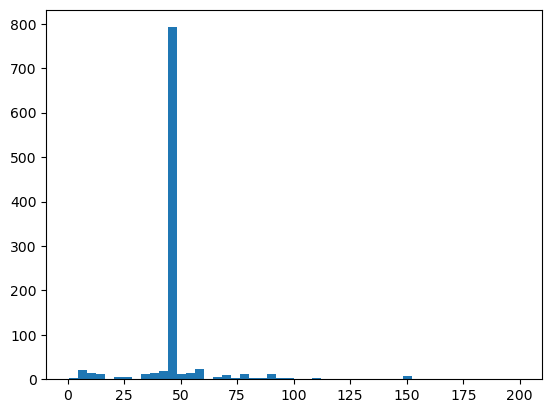

In [28]:
# Plot a distribution of the max_cap_M_m3_per_d attribute of the pipe segments. Bin all cap > 50000 into one bin
max_cap_M_m3_per_d = scigrid_pipe_segments_df['max_cap_M_m3_per_d'].values
max_cap_M_m3_per_d[max_cap_M_m3_per_d > 50000] = 50000
plt.hist(max_cap_M_m3_per_d, bins=50)
plt.show()

# Saving dataframes and graph objects to files

In [29]:
# Saving the scigrid_nodes_df and scigrid_pipe_segments_df to csv in the processed_data folder
scigrid_nodes_df.to_csv('processed_data/scigrid_nodes.csv', index=False)
scigrid_pipe_segments_df.to_csv('processed_data/scigrid_pipe_segments.csv', index=False)

In [30]:
# Saving the multi di-graph to a pickle file
with open('graph_objects/G_multi_directed.pickle', 'wb') as file:
    dill.dump(G_multi_directed, file)

# Saving the simple di-graph to a pickle file
with open('graph_objects/G_simple_directed.pickle', 'wb') as file:
    dill.dump(G_simple_directed, file)

# Saving the multi un-graph to a pickle file
with open('graph_objects/G_multi_undirected.pickle', 'wb') as file:
    dill.dump(G_multi_undirected, file)

# Saving the simple un-graph to a pickle file
with open('graph_objects/G_simple_undirected.pickle', 'wb') as file:
    dill.dump(G_simple_undirected, file)

In [31]:
# Using folium, write a function that allows us to plot the graph on a map with nodes and edges, but highlight
# a specific node with a different color

def plot_graph_on_map(G, nodes_df, edges_df, highlight_node=None):
    # Create a map
    m = folium.Map(location=[54.5260, 15.2551], zoom_start=4)

    # Have the map show the English map names
    folium.TileLayer('cartodbpositron').add_to(m)

    # Create feature groups for nodes and pipe segments
    node_group = folium.FeatureGroup(name='Nodes')
    pipe_group = folium.FeatureGroup(name='Pipe Segments')

    # Add nodes to the node group
    for index, row in nodes_df.iterrows():
        # Get the columns of the row, and add the columns as attributes to the node
        attributes = dict(row)
        if row['id'] == highlight_node:
            folium.Marker([row['lat'], row['long']], popup=row['id'], icon=folium.Icon(color='red')).add_to(node_group)
        else:
            folium.Marker([row['lat'], row['long']], popup=row['id']).add_to(node_group)

    # Add pipe segments to the pipe group
    for index, row in edges_df.iterrows():
        # Get the columns of the row, and add the columns as attributes to the edge
        attributes = dict(row)
        folium.PolyLine([(row['from_lat'], row['from_long']), (row['to_lat'], row['to_long'])], color="red", weight=2.5, opacity=1).add_to(pipe_group)

    # Add feature groups to the map
    node_group.add_to(m)
    pipe_group.add_to(m)

    # Add layer control to the map
    folium.LayerControl().add_to(m)

    return m

# Plot the simple directed graph on a map, highlighting the node 'NO_N_15'
m = plot_graph_on_map(G_simple_directed, scigrid_nodes_df, scigrid_pipe_segments_df, highlight_node='INET_N_1333')

In [32]:
m